## Loading Libraries and Training Data

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score

import joblib

In [2]:
data = pd.read_csv("../data/processed/scaled_EURUSD_daily.csv", index_col=0, parse_dates=True)
data.head()

,Open,High,Low,Close,MA20,MA50,Rolling_STD,Daily_Return,Volatility,Upper_Band,...,High_Low_Diff,Volatility_Price_Ratio,Momentum,Rolling_Return_5d,MA20_MA50_Interaction,Close_Volatility_Interaction,EMA20,EMA50,MACD,Signal_Line
date,,,,,,,,,,,,,,,,,,,,,
2014-11-23,2.191889,2.257424,2.252358,2.192606,2.266625,1.613936,-0.412957,0.954561,2.01357,2.215342,...,-0.160033,-0.556635,0.550805,1.092093,2.015158,2.658475,2.219578,2.257584,0.092931,0.093239
2014-11-24,2.308272,2.330381,2.312030,2.302185,2.266625,1.613936,-0.412957,0.954561,2.01357,2.215342,...,0.022916,-0.563156,0.550805,1.092093,2.015158,2.689204,2.230200,2.262066,0.128314,0.100489
2014-11-25,2.389062,2.416758,2.384088,2.391431,2.266625,1.613936,-0.412957,0.775757,2.01357,2.215342,...,0.219317,-0.568423,0.550805,1.092093,2.015158,2.714231,2.248461,2.270022,0.187758,0.118470
2014-11-26,2.439155,2.409953,2.424995,2.439066,2.266625,1.613936,-0.412957,0.417363,2.01357,2.215342,...,-0.464050,-0.571217,0.550805,1.092093,2.015158,2.727590,2.269600,2.279614,0.254458,0.146521
2014-11-27,2.350267,2.350416,2.359130,2.356410,2.266625,1.613936,-0.412957,-0.694317,2.01357,2.215342,...,-0.367195,-0.566361,0.550805,1.092093,2.015158,2.704410,2.280713,2.285450,0.285147,0.175250


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2608 entries, 2014-11-23 to 2024-11-22
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Open                          2608 non-null   float64
 1   High                          2608 non-null   float64
 2   Low                           2608 non-null   float64
 3   Close                         2608 non-null   float64
 4   MA20                          2608 non-null   float64
 5   MA50                          2608 non-null   float64
 6   Rolling_STD                   2608 non-null   float64
 7   Daily_Return                  2608 non-null   float64
 8   Volatility                    2608 non-null   float64
 9   Upper_Band                    2608 non-null   float64
 10  Lower_Band                    2608 non-null   float64
 11  Bollinger_Bandwidth           2608 non-null   float64
 12  Lag1_Close                    2608 non-null 

----
## Split data into Training and Testing sets

In [4]:
target = 'Close'
features = [col for col in data.columns if col != target]

train_size = int(len(data) * 0.8)

train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

X_train, y_train = train_data[features], train_data[target]
X_test, y_test = test_data[features], test_data[target]

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")

Training set: (2086, 32), (2086,)
Testing set: (522, 32), (522,)


----

## Feature Selection

In this section, we will identify the most important features for predicting the target variable (`Close`).

### Recursive Feature Elimination (RFE)
- **Methodology:**
  - Use Recursive Feature Elimination with Random Forest to evaluate subsets of features.
  - Start with all features and iteratively remove the least important ones.
  - Stop when a specified number of features are selected (e.g., top 10).
- **Pros:**
  - Captures interactions between features.
  - Provides a more refined selection.
- **Cons:**
  - Computationally expensive, especially with a large number of features.
  - Requires careful tuning of the number of features to retain.

____

In [5]:
def evaluate_feature_counts(max_features):
    results = {}
    for n in range(5, max_features + 1, 5):
        rfe = RFE(estimator=RandomForestRegressor(random_state=42), n_features_to_select=n)
        rfe.fit(X_train, y_train)
        selected_features = X_train.columns[rfe.support_]
        
        # Cross-validate on selected features
        rf_model = RandomForestRegressor(random_state=42)
        cv_scores = cross_val_score(rf_model, X_train[selected_features], y_train, cv=5, scoring='neg_mean_squared_error')
        results[n] = -np.mean(cv_scores)
    
    return results

feature_results = evaluate_feature_counts(max_features=20)
print(feature_results)

{5: 0.03148781983829414, 10: 0.032496579201930414, 15: 0.03238107024276016, 20: 0.032955655980930525}


In [6]:
n = min(feature_results, key=feature_results.get)
rf_model = RandomForestRegressor(random_state=42)
rfe = RFE(estimator=rf_model, n_features_to_select=n, step=1)

# Fit RFE on the training data
rfe.fit(X_train, y_train)
rfe_selected_features = X_train.columns[rfe.support_]
print(f"Selected Features by RFE: {list(rfe_selected_features)}")

Selected Features by RFE: ['Open', 'High', 'Low', 'Upper_Band', 'Rate_of_Change']


In [7]:
X_train_rfe = X_train[rfe_selected_features]
X_test_rfe = X_test[rfe_selected_features]

# new Random Forest model with selected features
rf_selected = RandomForestRegressor(random_state=42)
rf_selected.fit(X_train_rfe, y_train)

y_pred = rf_selected.predict(X_test_rfe)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance with Selected Features:\nMSE: {mse:.4f}, R^2: {r2:.4f}")

Model Performance with Selected Features:
MSE: 0.0000, R^2: 0.9997


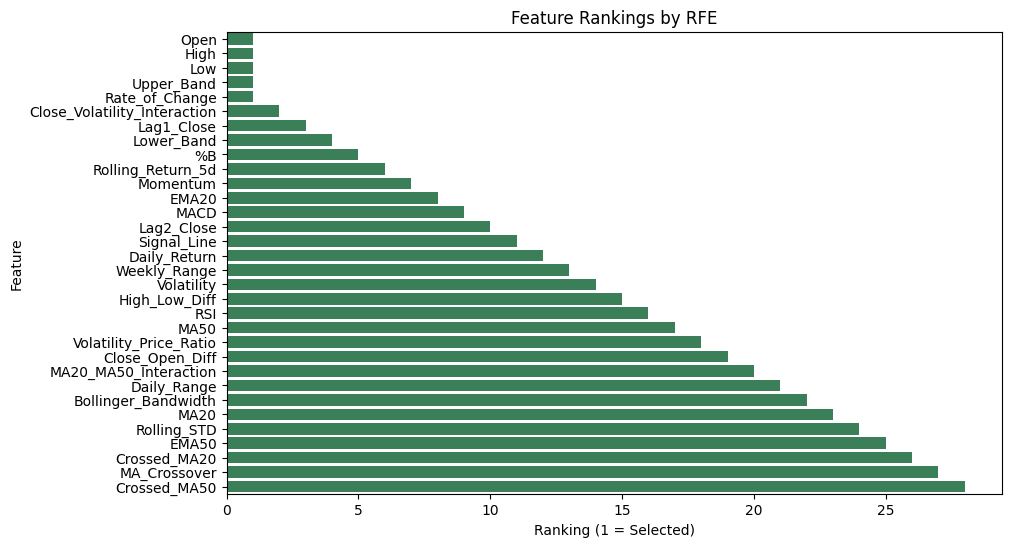

In [8]:
#DataFrame for feature rankings
feature_ranking = pd.DataFrame({
    'Feature': X_train.columns,
    'Ranking': rfe.ranking_
}).sort_values(by='Ranking')
plt.figure(figsize=(10, 6))
sns.barplot(x='Ranking', y='Feature', data=feature_ranking, color='seagreen')
plt.title('Feature Rankings by RFE')
plt.xlabel('Ranking (1 = Selected)')
plt.ylabel('Feature')
plt.show()

----
## Hyperparameter Tuning
Now that we have the final feature set, the next step is to optimize the Random Forest model hyperparameters.

#### Key Parameters to Tune:
- n_estimators: Number of trees (e.g., [50, 100, 200]).
- max_depth: Maximum depth of trees (e.g., [5, 10, 20, None]).
- min_samples_split: Minimum number of samples required to split a node (e.g., [2, 5, 10]).
- min_samples_leaf: Minimum number of samples required in a leaf node (e.g., [1, 2, 4]).
- max_features: Number of features to consider at each split (e.g., ['auto', 'sqrt', 'log2']).

In [10]:
#parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]  # Fixed options
}

# Initialize Grid Search
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

# Fit Grid Search
grid_search.fit(X_train_rfe, y_train)

best_rf = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best CV Score: {-grid_search.best_score_}")

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100;

In [25]:
# Extract all results from GridSearchCV
cv_results = pd.DataFrame(grid_search.cv_results_)

# Sort by mean test score
cv_results = cv_results.sort_values(by="mean_test_score", ascending=False)

# Extract the top 3 parameter sets
top_3_params = cv_results.head(3)[['params', 'mean_test_score']]
print("Top 3 Hyperparameter Sets:")

pd.set_option('display.max_colwidth', None)
print(top_3_params)

Top 3 Hyperparameter Sets:
                                                                                                            params  mean_test_score
137    {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}        -0.031408
218    {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}        -0.031409
299  {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}        -0.031409


In [13]:
model_metrics = []

# Evaluate the top 3 models on the test set
for i, row in top_3_params.iterrows():
    params = row['params']
    
    # Train the model with the given hyperparameters
    model = RandomForestRegressor(random_state=42, **params)
    model.fit(X_train_rfe, y_train)
    
    # Predict on the test set
    y_test_pred = model.predict(X_test_rfe)
    
    # Calculate accuracy metrics
    mse = mean_squared_error(y_test, y_test_pred)
    mae = mean_absolute_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)
    
    # Store results rounded to 6 decimal points
    model_metrics.append({
        "Model": f"Model_{i+1}",
        "MSE": round(mse, 6),
        "MAE": round(mae, 6),
        "R²": round(r2, 6)
    })

results_df = pd.DataFrame(model_metrics)
results_df

,Model,MSE,MAE,R²
0,Model_138,0.000029,0.002342,0.999702
1,Model_219,0.000029,0.002324,0.999704
2,Model_300,0.000029,0.002324,0.999704


----
## Retrain on Full dataset

This maximizes the predictive power of these models before testing them on the unseen dataset in the `model_comparison` notebook.

In [26]:
# Combine train and test sets into a full dataset
X_full = pd.concat([X_train_rfe, X_test_rfe], axis=0)
y_full = pd.concat([y_train, y_test], axis=0)

print(f"Full dataset shape: {X_full.shape}")

Full dataset shape: (2608, 5)


In [31]:
# Train and save the top 3 models
for i, row in top_3_params.iterrows():
    params = row['params']  # Get hyperparameters for the model
    
    # Train the model on the full dataset
    model = RandomForestRegressor(random_state=42, **params)
    model.fit(X_full, y_full)
    
    # Save the model
    joblib.dump(model, f"../models/EURUSD_daily/rf_model_full_{i+1}.joblib")
    print(f"Model {i+1} trained on the full dataset and saved as 'rf_model_full_{i+1}.joblib'.")

Model 138 trained on the full dataset and saved as 'rf_model_full_138.joblib'.
Model 219 trained on the full dataset and saved as 'rf_model_full_219.joblib'.
Model 300 trained on the full dataset and saved as 'rf_model_full_300.joblib'.


In [32]:
# Verify saved models and their hyperparameters
for i in range(1, 4):
    model = joblib.load(f"../models/EURUSD_daily/rf_model_full_{i}.joblib")
    print(f"Loaded Model {i} with Hyperparameters: {model.get_params()}")

FileNotFoundError: [Errno 2] No such file or directory: '../models/EURUSD_daily/rf_model_full_1.joblib'